<a href="https://colab.research.google.com/github/Bhandari007/Timeseries-and-sequence-models/blob/main/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Sunspots with Neural Networks

In this lab, we will train on the Sunspost dataset: a monthly record os sunspot numbers from Jan 1749 to Jul 2018. We will build a deep neural network composed of dense layers.

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format = "-", start = 0, end = None, title = None, xlabel = None, ylabel = None, legend = None):
  
  # Setup dimensions of the graph figure
  plt.figure(figsize=(10,6))

  # Check if there are more than two series to plot
  if type(y) is tuple:
    # loop over the y elements
    for y_curr in y:
      # Plot the x and current y values
      plt.plot(x[start:end], y_curr[start:end], format)

  else:
    plt.plot(x[start:end], y[start:end], format)

  # Label the x-axis
  plt.xlabel(xlabel)

  # Label the y-axis
  plt.ylabel(ylabel)

  # Set the legend
  if legend:
    plt.legend(legend)

  # Overlay a grid on the graph
  plt.grid(True)

  # Draw the graph on screen
  plt.show()

# Download and Preview the Datset

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2022-10-30 12:12:15--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-10-30 12:12:15 (82.3 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [4]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


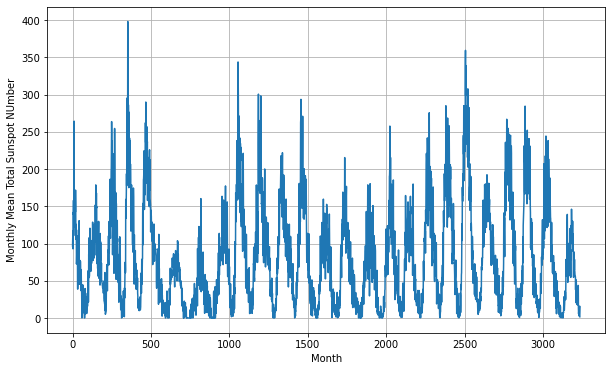

In [6]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open("./Sunspots.csv") as csvfile:
  # Initialize reader
  reader = csv.reader(csvfile, delimiter = ",")

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))
  
# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel = "Month", ylabel = "Monthly Mean Total Sunspot NUmber")


# Split the Dataset

In [7]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare Features and Labels

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


In [9]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the Model

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape = [window_size], activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


# Tune the Learning Rate

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch/20)
)

# Initalize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
93/93 [==============================] - 2s 5ms/step - loss: 196.4267 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 6ms/step - loss: 194.2125 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 4ms/step - loss: 191.7364 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 5ms/step - loss: 188.9924 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 185.9627 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 182.6194 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 5ms/step - loss: 178.9362 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 5ms/step - loss: 174.8818 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 5ms/step - loss: 170.4279 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 5ms/step - loss: 165.5535 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

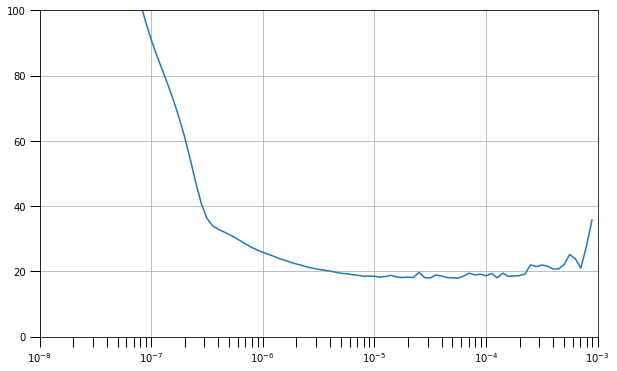

In [13]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Train the Model

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [15]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 2s 6ms/step - loss: 28.9074 - mae: 29.4024
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 20.6112 - mae: 21.1047
Epoch 3/100
93/93 [==============================] - 1s 5ms/step - loss: 19.2901 - mae: 19.7828
Epoch 4/100
93/93 [==============================] - 1s 4ms/step - loss: 18.9498 - mae: 19.4430
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 18.3347 - mae: 18.8255
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 18.4981 - mae: 18.9900
Epoch 7/100
93/93 [==============================] - 1s 5ms/step - loss: 18.1866 - mae: 18.6790
Epoch 8/100
93/93 [==============================] - 1s 5ms/step - loss: 17.9059 - mae: 18.3984
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 17.7157 - mae: 18.2070
Epoch 10/100
93/93 [==============================] - 1s 5ms/step - loss: 17.6425 - mae: 18.1344
Epoch 11/100
93/93 [===================

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

8/8 [==============================] - 0s 15ms/step


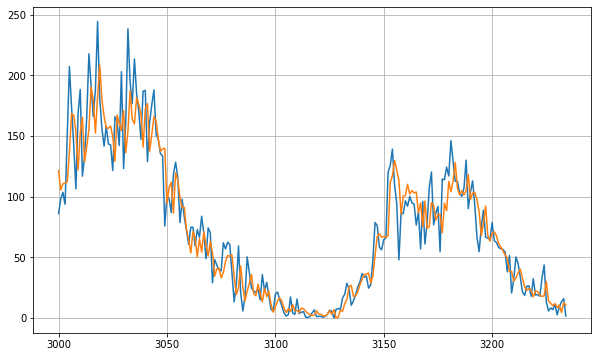

In [17]:
forecast_series = series[split_time- window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [18]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.346681
